# Predicting voter habits: A Toy example to learn about trees

In this work book we are going to:
 1. Generate a training, validation and testing data of two populations of voters
 2. Train a simple decision tree to categorize this dat 

## Generating the Data

First we're going to create functions that return an arbirtary number of datapoints of either population of voter.

In [2]:
import numpy as np

# Returns n_points randomly distributed about an anulus
def get_data_in_anulus(min_r,max_r,classification = 0, n_points = 500):
    theta = np.random.uniform(0.0,2*3.14,n_points) 
    r     = np.random.uniform(min_r,max_r,n_points)
    return np.column_stack((
        r*np.cos(theta),
        r*np.sin(theta), 
        classification*np.ones(n_points)
        ))

#Get data distributed normally 
def get_data(mu_x,sigma_x,mu_y,sigma_y,classification=0,n_points = 500  ):
    return np.column_stack((
        np.random.normal(mu_x, sigma_x, n_points),
        np.random.normal(mu_y, sigma_y, n_points), 
        classification*np.ones(n_points)
        ))

Now lets create and store 500 data points, splitting it into training and test data. 

In [31]:
n_data_points,n_valid_points = 500,250
reds = get_data_in_anulus(2, 5,
                classification=1,
                n_points=n_data_points
               )

blues = get_data(0, 1.25,
                 0,1.25,
                classification=0,
                n_points=n_data_points
                )

train_data       = np.append(reds[:n_valid_points,:],blues[:n_valid_points,:],axis=0)
test_data = np.append(reds[n_valid_points:,:],blues[n_valid_points:,:],axis=0)
print "Produced training data: ", len(train_data)

Produced training data:  500


## Plot the data 

We'll use matplotlib to display the data 

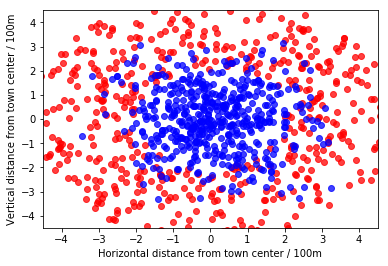

In [7]:
import matplotlib.pyplot as plt

plt.scatter(reds[:,0], reds[:,1],  c='red', alpha=0.75)
plt.scatter(blues[:,0], blues[:,1],  c='blue', alpha=0.75)
plt.xlabel('Horizontal distance from town center / 100m')
plt.ylabel('Vertical distance from town center / 100m')
plt.ylim([-4.5,4.5])
plt.xlim([-4.5,4.5])
plt.savefig('total_population.png', dpi = 300)
plt.show()


## Fit and draw the tree

Next up is sklearn which has a very clean implementation of many algorithms - the one of interest for this example is DecisionTreeClassifier 


In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,roc_auc_score

print "Fitting a depth one tree to the training data: ", len(train_data)
clf = DecisionTreeClassifier(max_depth =1)

#the features vector setare the first two points of the train_data arrays generated above
train_data_x = train_data[:,:2]
#the response vectore set is the classification, and will be deonted by y 
train_data_y = train_data[:,-1]
#fit the tree
clf.fit(train_data_x,train_data_y)


#evaluate the accuracy of this simple classifier
y_true = test_data[:,-1]
y_pred =  clf.predict(test_data[:,:2])
print "Accuracy: ",accuracy_score(y_true,y_pred)

Fitting a depth one tree to the training data:  500
Accuracy:  0.638


The next step we is to draw the data points with a colored background representing the prediction the tree gives.  

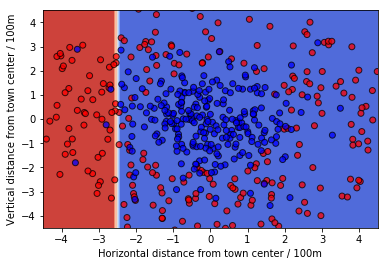

In [32]:
def plot_classifier_boundary(clf,    x_min=-30, x_max =30,    y_min=-10, y_max = 10,    plot_step = 0.2,c_map = plt.cm.coolwarm):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step),
                        )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=c_map)

    
#draw the boundaries
plot_classifier_boundary(clf,x_min=-5,x_max=5,y_min=-5.1,y_max=5.1)

#sort the colors
scaled_z = (train_data[:,-1] - train_data[:,-1].min()) / train_data[:,-1].ptp()
colors = plt.cm.bwr(scaled_z)

plt.scatter(train_data[:,0], train_data[:,1],  linewidth=1
            ,edgecolors='black',alpha=0.75, c=colors)
plt.xlabel('Horizontal distance from town center / 100m')
plt.ylabel('Vertical distance from town center / 100m')
plt.ylim([-4.5,4.5])
plt.xlim([-4.5,4.5])
plt.savefig('depth_one_tree.png', dpi = 300)
plt.show()

# Overfitting example

An easy way to demonstrate how easy trees are to overfit is to remove the stop criteria of max_depth and min_leaf_

Test  Accuracy:  0.844
Train Accuracy:  1.0


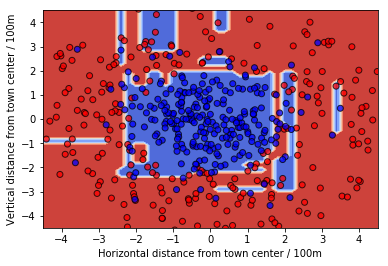

In [45]:
clf = DecisionTreeClassifier()
clf.fit(train_data_x,train_data_y)

y_pred =  clf.predict(test_data[:,:2])
print "Test  Accuracy: ",accuracy_score(y_true,y_pred)
print "Train Accuracy: ",accuracy_score(train_data_y,clf.predict(train_data_x))

plot_classifier_boundary(clf,x_min=-5,x_max=5,y_min=-5.1,y_max=5.1)
plt.scatter(train_data[:,0], train_data[:,1],  linewidth=1
            ,edgecolors='black',alpha=0.75, c=colors)
plt.xlabel('Horizontal distance from town center / 100m')
plt.ylabel('Vertical distance from town center / 100m')
plt.ylim([-4.5,4.5])
plt.xlim([-4.5,4.5])
plt.savefig('no_max_depth_tree.png', dpi = 300)
plt.show()

# Reasonable hyperparamaters 

Now let's add the restriction that at least 25 datapoints must be on the final leaf, before the lack of a requirement like this resulted in many datapoints belonging to a single leaf.

Fitting on training data:  500


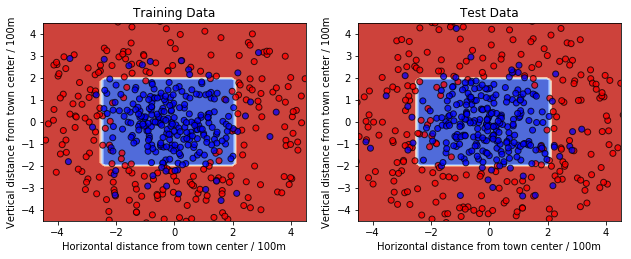

Test accuracy:  0.87
Train accuracy:  0.894


In [47]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import accuracy_score,roc_auc_score
import graphviz 

print "Fitting on training data: ", len(train_data)
clf = DecisionTreeClassifier(min_samples_leaf=25)
clf.fit(train_data[:,:2],train_data[:,-1])

#Draw the train and test datasets side by side 
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2,3.5,1)
plot_classifier_boundary(clf,x_min=-5,x_max=5,y_min=-5.1,y_max=5.1)
plt.scatter(train_data[:,0], train_data[:,1],  linewidth=1
            ,edgecolors='black',alpha=0.75,c=colors,
           )
plt.title('Training Data')
plt.xlabel('Horizontal distance from town center / 100m')
plt.ylabel('Vertical distance from town center / 100m')
plt.ylim([-4.5,4.5])
plt.xlim([-4.5,4.5])

ax = fig.add_subplot(2,3.5,2)
scaled_z = (test_data[:,-1] - test_data[:,-1].min()) / test_data[:,-1].ptp()
colors = plt.cm.bwr(scaled_z)
plot_classifier_boundary(clf,x_min=-5,x_max=5,y_min=-5.1,y_max=5.1)
plt.scatter(test_data[:,0], test_data[:,1],  linewidth=1
            ,edgecolors='black',alpha=0.75,c=colors,
           )

plt.title('Test Data')
plt.xlabel('Horizontal distance from town center / 100m')
plt.ylabel('Vertical distance from town center / 100m')
plt.ylim([-4.5,4.5])
plt.xlim([-4.5,4.5])

plt.savefig('decision_boundary.png', dpi = 300)
plt.show()


#validte this
y_true = test_data[:,-1]
y_pred =  clf.predict(test_data[:,:2])
acc = accuracy_score(y_true,y_pred)
train_acc =  accuracy_score(clf.predict(train_data[:,:2]),train_data[:,-1])
print "Test accuracy: ", acc
print "Train accuracy: ", train_acc